In [1]:
import torch 
import wandb
import numpy as np
from dataset_class import get_data, classes_RW, config
import onnxruntime
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniconda/base/envs/bzzt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
wandb.login()

device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: nnarotam03 (shlongthesheep). Use `wandb login --relogin` to force relogin


Accuracy: 0.5546935608999224
F1 Score: 0.5583970622327346


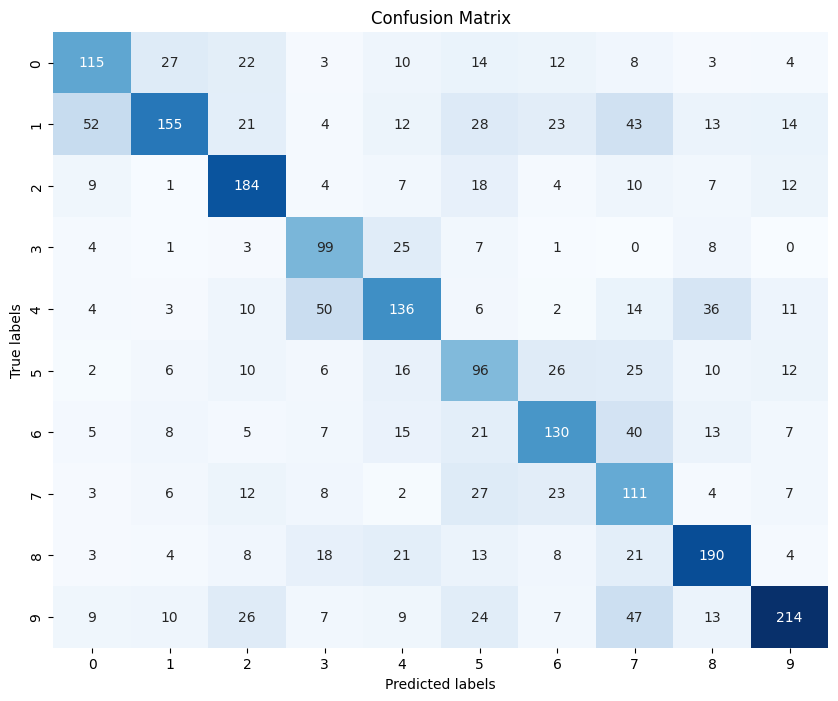

In [3]:
ort_sesh = onnxruntime.InferenceSession("ConvNet.onnx")
test_loader = get_data(value=1, loader=True)

mis_class = {class_label: [] for class_label in range(len(classes_RW))}
preds = []
grd_tru = []

for images, labels in test_loader:
    images, labels = images.to(device).numpy(), labels.to(device).numpy()
    ort_outputs = ort_sesh.run(None, {'input': images})
    batch_preds = np.argmax(ort_outputs[0], axis=1)

    for image, pred, true_lbl in zip(images, batch_preds, labels):
        if pred != true_lbl:
            mis_class[true_lbl].append((image, pred))
            
    preds.extend(batch_preds)
    grd_tru.extend(labels)

accuracy = accuracy_score(preds, grd_tru)
f1 = f1_score(preds, grd_tru, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)

conf_matrix = confusion_matrix(preds, grd_tru)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [7]:
with wandb.init(project="wildlife_fin_run", config=config):
    wandb.log({"Test Accuracy": accuracy, "Test F1 Score": f1})
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=grd_tru, preds=preds,
                        class_names=classes_RW)})


Test Accuracy,▁
Test F1 Score,▁
Test Accuracy,0.55469
Test F1 Score,0.5584


In [5]:
def imshow(imgs, realbl):
    row = 1
    cols = 3

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(classes_RW[realbl], y = 0.65)

    post = 0
    for img, id in imgs:
        post += 1
        fig.add_subplot(row, cols, post) 
        plt.axis('off') 
        plt.title(classes_RW[id], y=-0.15)
        plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

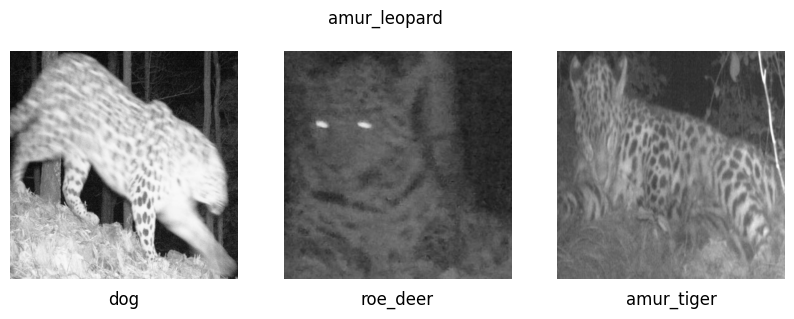

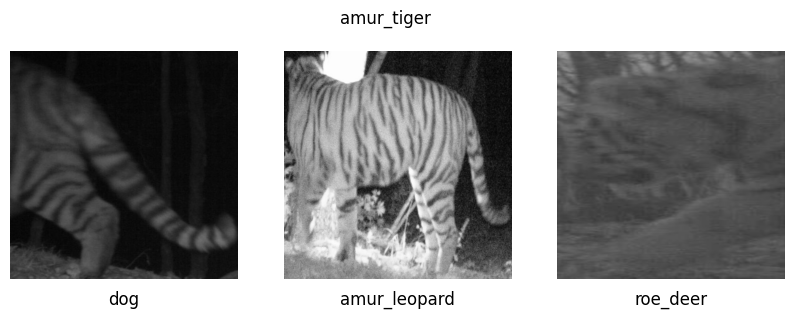

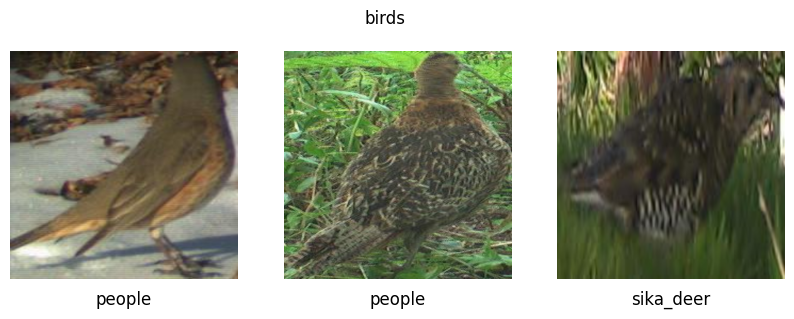

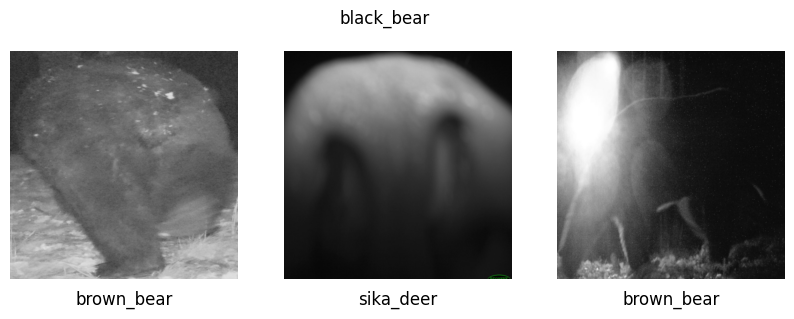

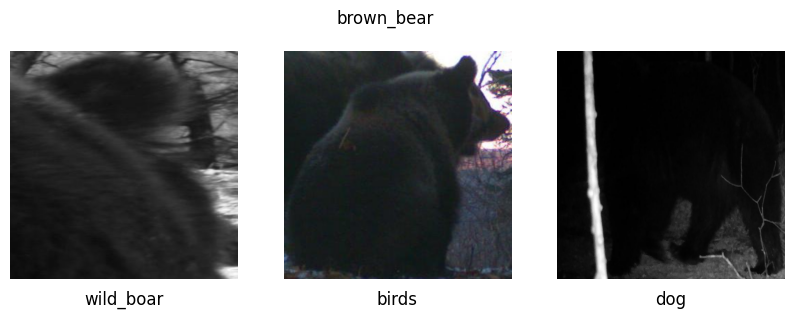

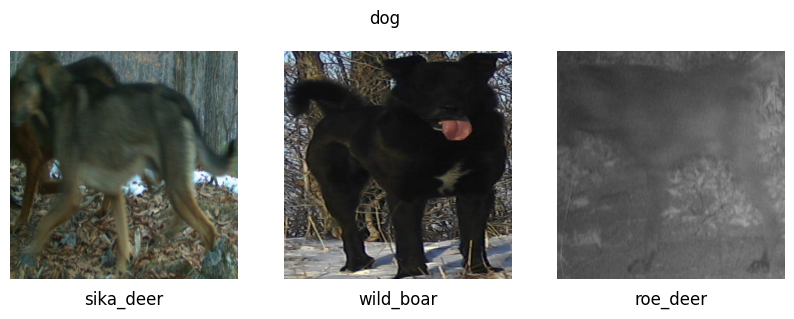

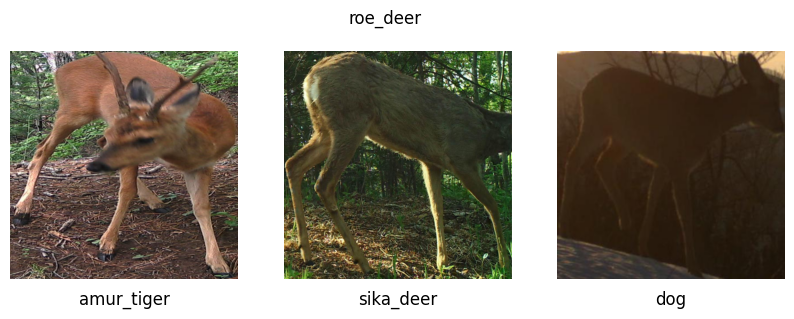

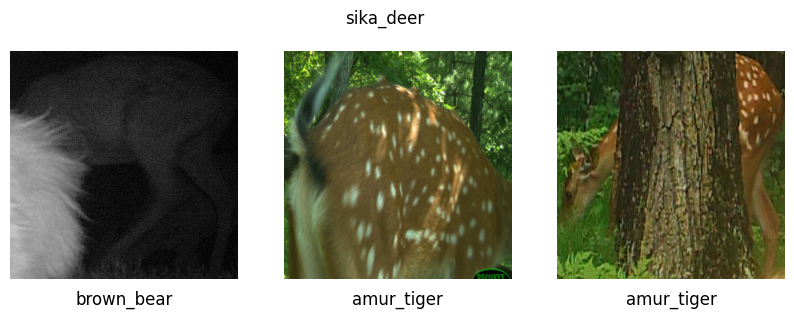

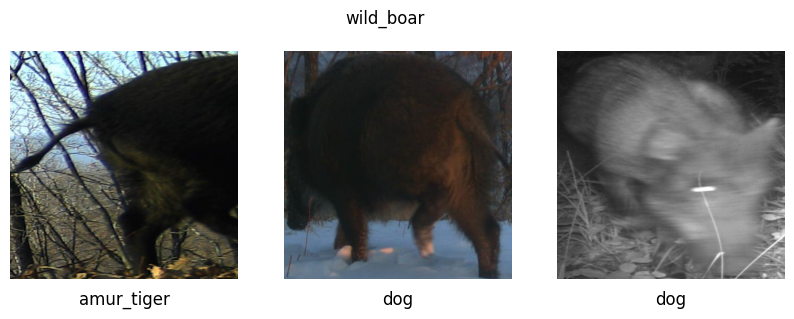

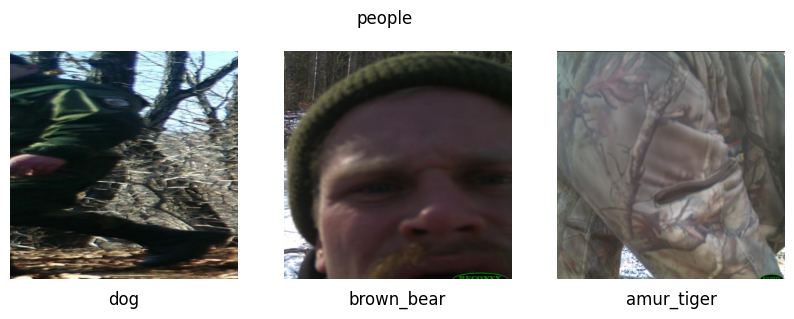

In [6]:
np.random.seed(0)

for i in range(len(classes_RW)):
    tru_lbl = classes_RW[i]
    mis_smpls = mis_class[i]
    mis_idx = np.random.choice(range(len(mis_smpls)), 3, replace=False)
    imshow([mis_smpls[x] for x in mis_idx], i)

In the wildlife dataset with classes such as "amur_leopard," "amur_tiger," "birds," "black_bear," "brown_bear," "dog," "roe_deer," "sika_deer," "wild_boar," and "people," misclassifications might occur due to subtle distinctions among species and environmental conditions. For instance, an image labeled as "amur_tiger" might exhibit obscured tiger markings or low visibility, leading to misclassification as "black_bear." Similarly, dense foliage in a "wild_boar" image might result in misclassification as "brown_bear" due to shared forest habitats. These challenges underscore the importance of diverse training data and refined model architectures to accurately capture nuanced features and enhance classification accuracy.

Misclassifications in the wildlife dataset may stem from ambiguous visual features or the lack of clear representations of the ground truth class in certain images. Images might resemble features of another class due to lighting, angles, or pose variations. Augmenting training data with diverse examples, fine-tuning model architectures to capture finer details, and implementing ensemble methods or transfer learning can mitigate misclassification errors. These strategies enhance the model's ability to discern intricate wildlife characteristics and improve classification accuracy across diverse conditions.